# Experiment of star graph from size 2 to 27 on ibmq_toronto, with measurement error mitigation proposed by Bravyi et al.

External packages by my own:
- bell_ineq.py \
importing the inequality by Baccari et al.

- graph_lib.py \
importing graph library such as making adjacency list of star graph

- graph_state_lib.py \
importing the circuit preparation functions for graph states

### circuits

[circquit of size 2 (term1), \
circquit of size 2 (term2), \
circquits of 2 qubit calibration, \
circquit of size 3 (term1), \
circquit of size 3 (term2), \
circquits of 3 qubit calibration, \
circquit of size 4 (term1), \
circquit of size 4 (term2), \
circquits of 4 qubit calibration, \
…, \
circquit of size n (term1), \
circquit of size n (term2), \
circquits of n qubit calibration]

## imports

### import qiskit libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time
import pdb

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.ignis.mitigation as mit
import qiskit.quantum_info as qi
# from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter

### import original library

In [3]:
import importlib
import star_bell_ineq
importlib.reload(star_bell_ineq)
from star_bell_ineq import *
import graph_lib
from graph_lib import *
import graph_state_lib
from graph_state_lib import *

### load account

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
# provider = IBMQ.get_provider(hub="ibm-q-utokyo", group="reservations", project="reservations")
print(provider)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


## create star graph information from size 2 to 27
we test the size from 2 to 27

change the number of 27 of "max_size = len(vertex_list[:27]) # largest graph size" if you want to try up to other size

In [5]:
vertex_list =  [ 8,
                11, 
                 5, 14,
                 9,  3, 13, 
                 2, 12, 16,
                 1, 15, 19,
                10,  0, 18, 20,
                  4, 22,  7, 21,
                 17, 25, 6, 23,
                 26, 24] # qubit layout
max_size = 27 # largest graph size
Fs = [[0] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_star_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution
graph_sizes = [len(adj_list) for adj_list in adj_lists]
system_size = len(vertex_list)

In [6]:
print("max_size:", max_size)
print("system_size:", system_size)
print("shots_per_circuit:", shots_per_circuit)
print("graph_sizes:", graph_sizes)

max_size: 27
system_size: 27
shots_per_circuit: 8192
graph_sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [7]:
 # indicate how to connect qubits
order = [[0,1],
         [0,2],[1,3],
         [0,4],[2,5],[3,6],
         [5,7],[6,8],[3,9], 
         [7,10],[8,11],[9,12],
         [8,13],[10,14],[11,15],[12,16],
         [10,17],[12,18],[13,19],[15,20],
         [15,21],[18,22],[19,23],[20,24],
         [22,25],[24,26]]

In [8]:
qubit_depths = [0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9]
print(qubit_depths)
print(len(qubit_depths))

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9]
27


## prepare quantum circuits (from size 2 to 27)

In [9]:
qcs = [refocusing_last_star_graph_state(size, order[:size-1], qubit_depths[:size], system_size) for size in range(1, max_size+1)]
qcs_list, nums_divide_list, nums_meas_cal_list, metadatas_list, _, initial_layouts_list = \
    prepare_grouping_star_graph_qcs_list(qcs, 
                                        adj_lists, 
                                        measure_last=True,
                                        optimization_level=0,
                                        initial_layouts=[vertex_list[:system_size]] * len(qcs),
                                        method="tensored",
                                        mitigation_limit=100)
print("the number of graph state circuits is: ", len(qcs_list))

the number of graph state circuits is:  104


In [10]:
ops_qcs_list = [qc.count_ops() for qc in qcs_list]
print(len(qcs_list), "quantum circuits")
print("length of initial_layouts_list: ", len(initial_layouts_list))

104 quantum circuits
length of initial_layouts_list:  104


In [11]:
qcs_depths = [qc.depth() for qc in qcs[1:]]
print("qcs_depth:", qcs_depths)

qcs_depth: [4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12]


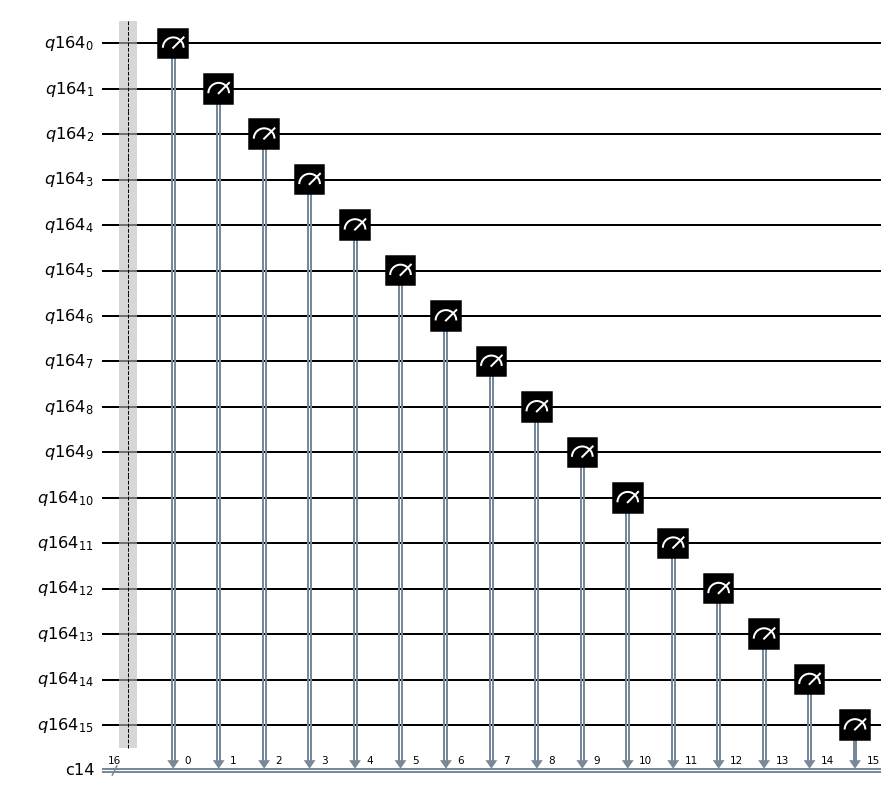

In [12]:
qcs_list[58].draw("mpl")

## cast jobs to ibmq_toronto and save job ids

indicate arbitrary job_ids_filename as you like

In [13]:
device = provider.backends.ibmq_toronto
backend = provider.get_backend('ibmq_toronto')

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  """Entry point for launching an IPython kernel.


In [14]:
"""
jobs = execute_circuits(qcs_list,
                        backend='ibmq_toronto', 
                        provider=provider, 
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=1,
                        initial_layout=initial_layouts_list)
print(len(jobs), "jobs")
"""

'\njobs = execute_circuits(qcs_list,\n                        backend=\'ibmq_toronto\', \n                        provider=provider, \n                        shots=shots_per_circuit,\n                        max_experiments=900,\n                        optimization_level=1,\n                        initial_layout=initial_layouts_list)\nprint(len(jobs), "jobs")\n'

In [15]:
job_ids_filename = "job_ids_toronto_star_retry.pkl"

In [16]:
# with open(job_ids_filename, "wb") as f:
#     pickle.dump([job.job_id() for job in jobs], f)

In [17]:
# with open("toronto_properties_star_retry.pkl", "wb") as f:
#     pickle.dump(device.properties(), f)

## Tensored

In [18]:
from typing import List, Union
class TensoredMitigation(object):
    
    def __init__(self, 
                 num_qubits: int, 
                 cal_matrices: List[np.array],
                 mit_pattern: List[List[int]] = None,
                 meas_layout: List[int] = None):
        """
        Initialize the Mitigation class
        
        Arguments
            num_qubits: number of qubits (int)
            cal_matrices: calibration matrices (list of 2 * 2 numpy array)
            meas_layout: the mapping from classical registers to qubits
        """
        self.num_qubits = num_qubits
        self.cal_matrices = cal_matrices
        self.mit_pattern = mit_pattern if mit_pattern is not None else [[i] for i in range(self.num_qubits)]
        self.pinv_matrices = None
        self.pinv_svd_matrices = None
        
        if meas_layout is None:
            meas_layout = [i for i in range(self.num_qubits)]
        meas_layout = meas_layout[::-1]  # reverse endian
        
        self.qubits_to_clbits = [-1 for _ in range(max(meas_layout) + 1)]
        for i, qubit in enumerate(meas_layout):
            self.qubits_to_clbits[qubit] = i
    
    def run_inv(self):
        """
        Prepare inverse calibration matrices.
        
        Internal Method.
        """
        if self.pinv_matrices is None:
            self.pinv_matrices = list(map(np.linalg.pinv, self.cal_matrices))

    def run_inv_svd(self):
        """
        Do singular value decomposition of all inverse calibration matrices.
        
        Internal Method.
        """
        self.run_inv()
        if self.pinv_svd_matrices is None:
            self.pinv_svd_matrices = list(map(np.linalg.svd, self.pinv_matrices))
    
    def flip_state(self, state: str, mat_index: int, flip_poses: List[int]) -> str:
        """
        Flip the state according to the chosen qubit positions
        
        Arguments
            state: label of focusing state (source state)
            mat_index: the digit to be flipped
            flip_poses: candidate of digit to be flipped
        """
        flip_poses = [pos for i, pos in enumerate(flip_poses) if (mat_index >> i) & 1]
        flip_poses = sorted(flip_poses)
        new_state = ""
        pos = 0
        for flip_pos in flip_poses:
            new_state += state[pos:flip_pos]
            new_state += str(int(state[flip_pos], 2) ^ 1)  # flip the state
            pos = flip_pos + 1
        new_state += state[pos:]
        return new_state

    def compute_index_of_cal_mat(self, state: str, pos_clbits: List[int]) -> int:
        """
        Return the index of (pseudo inverse) calibration matrix for the input quantum state
        """
        sub_state = ""
        for pos in pos_clbits:
            sub_state += state[pos]
        return int(sub_state, 2)
    
    def mitigate_one_state(self, target_state: str, counts: dict):
        """
        Mitigate one state using inverse calibration matrices.
        Time complexity of this function: O(self.num_qubits * shots)
        
        Arguments
            target_state: quanutum state to be mitigated
            counts: raw counts
        Returns
            new_count: mitigated count of target state (int)
        """
        new_count = 0
        for source_state in counts:# O(shots)
            tensor_elem = 1.
            for pinv_mat, pos_qubits in zip(self.pinv_matrices, self.mit_pattern):
                pos_clbits = [self.qubits_to_clbits[qubit] for qubit in pos_qubits] # if completely tensored, then len(pos_clbits) == 1
                first_index = self.compute_index_of_cal_mat(target_state, pos_clbits)
                second_index = self.compute_index_of_cal_mat(source_state, pos_clbits)
                tensor_elem *= pinv_mat[first_index, second_index]
            new_count += tensor_elem * counts[source_state]
        return new_count
    
    def fast_subproblem(self, x_sorted: np.array):
        """
        Remove the negative elements from mitigated probability vector with sum(x_sorted) = 1
        
        Arguments
            x_sorted: sorted probability vector with sum(x_sorted) = 1, x_sorted is sorted in the descending order
        """
        x_tilde = []
        bound = len(x_sorted) - 1
        accumulator = 0
        for _ in x_sorted:
            # print(bound, x_sorted[bound], accumulator)
            if x_sorted[bound] + accumulator / (bound + 1) < 0:
                accumulator += x_sorted[bound]
                x_tilde.append(0)
                bound -= 1
            else:
                break
        for i in range(bound + 1)[::-1]:
            x_tilde.append(x_sorted[i] + accumulator / bound)
            
        return list(reversed(x_tilde))
    
    def apply(self,
              counts: dict,
              shots: int = None,
              method: str = "default"):
        """
        Do whole process of mitigation

        Arguments
            counts: raw counts (dict of str to int)
            shots: total number of shot (int)
            method: mitigation option (str)
            
                * "default": `O(n2^n)` time and `O(2^n)` space
                    
                
                * "memory_efficient": `O(2^n)` times and `O()`
                    
        Returns
            mitigated_counts: mitigated counts (dict of str to float)
        """
        
        if shots is None:
            shots = sum(counts.values())
        
        # make probability vector (dict)
        y = {state : counts[state] / shots for state in counts}
        
        # compute pseudo inverse and svd of all calibartion matrices
        self.run_inv_svd()

        if method=="memory_efficient":
            return
        else:
            # mitigate raw counts y using tensored mitigation
            x = np.zeros(2 ** self.num_qubits, dtype=float)
            for state_idx in range(2 ** self.num_qubits):
                x[state_idx] = self.mitigate_one_state(format(state_idx, "0" + str(self.num_qubits) + "b"), y)
            print("sum of mitigated probability vector x:", sum(x))
        
            # sort the mitigated counts x in descending order -> O(n * 2^n) time
            x_argsorted = np.argsort(x)[::-1]
            x_sorted = x[x_argsorted]
        
            # do fast algorthm by Smolin et al. -> O(2^n) time
            x_tilde = self.fast_subproblem(x_sorted)
            # print("len(x_tilde): ", len(x_tilde))
            print("sum of mitigated probability vector x_tilde:", sum(x_tilde))
        
            # recover the finally mitigated counts dict
            new_counts = {format(state_idx, "0"+ str(self.num_qubits) + "b"): x_tilde[i] * shots for i, state_idx in enumerate(x_argsorted[:len(x_tilde)])}
        
            return new_counts

In [19]:
def arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100):
    pos = 0
    results_graph_states = []
    results_meas_cal = []
    for i, (nums_divide, nums_meas_cal) in enumerate(zip(nums_divide_list, nums_meas_cal_list)): # graph wise
        for num_divide in nums_divide: # term wise
            results_graph_states += results_list[pos:pos + num_divide]
            pos += num_divide
        if i < limit: # start from 2
            for num_meas_cal in nums_meas_cal: # term wise
                results_meas_cal.append(merge_results(results_list[pos:pos + 2]))
                pos += num_meas_cal
    return results_graph_states, results_meas_cal

In [20]:
with open(job_ids_filename, "rb") as f:
     job_ids = pickle.load(f)
results_jobs_list = job_ids_to_result(job_ids, device)
print(len(results_jobs_list))
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
del results_jobs_list
results_graph_states, results_meas_cal = arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100)
print("length of results_meas_cal: ", len(results_meas_cal))
del results_list

1
length of results_list:  104
length of results_meas_cal:  26


In [21]:
counts_dict_list = results_list_to_counts_dict_list(results_graph_states)
print("length of counts_dict_list: ", len(counts_dict_list))
del results_graph_states

length of counts_dict_list:  52


In [22]:
tensored_meas_mitigator_list = []
for n in range(2,max_size + 1):
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_fitter = TensoredMeasFitter(results_meas_cal[n - 2], mit_pattern=mit_pattern).filter
    meas_filter = TensoredMitigation(n, meas_fitter.cal_matrices, mit_pattern)
    tensored_meas_mitigator_list.append( meas_filter )
print("length of tensored_meas_mitigator_list: ", len(tensored_meas_mitigator_list))
del results_meas_cal

length of tensored_meas_mitigator_list:  26


## compute correlation

In [24]:
def analyze_circuits_tensored(adj_lists, counts_dict_list, tensored_meas_mitigator_list=None, limit=100, method='fast', threshold=0.1):
    """
    Input
        adj_lists         : list of adjacency list
        counts_list       : list of int list (list of counts)
        meas_mitigator : measurement mitigator
    Output
        expval_all_list : list of float (correlation of each graph)
        stddev_all_list : list of float (standard deviation of each graph)
        Es_all_list   : list of list (term-wise correlation of each graph)
        Ds_all_list   : list of list (term-wise stddev of each graph)
    """
    expval_all_list, stddev_all_list, Es_all_list, Ds_all_list, times = [], [], [], [], []
    # begin = 0
    for adj_list in adj_lists:
        t1 = time.time()
        n = len(adj_list)
        if n > limit:
            break
        print("graph size:", n)
        if n <= 1:
            print("skipped\n")
            expval_all_list.append(0)
            stddev_all_list.append(0)
            Es_all_list.append([])
            Ds_all_list.append([])
            continue

        # for the first term
        print("first term")
        counts = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2)], method=method) # n = 2 -> 0, n = 10 -> 16
        print("mitigation completed")
        expval1, stddev1 = mit.expectation_value(counts, 
                                                 qubits=range(n),
                                                 clbits=range(n),
                                                 meas_mitigator=None)
        Es_1, Ds_1 = [expval1], [stddev1]
        # begin += 1 # update index of counts_dict_list


        # for the second term
        print("second term")
        Es_2, Ds_2 = [], []
        sum_expval2, sum_stddev2 = 0, 0
        counts = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2) + 1], method=method) # n = 2 -> 1, n = 10 -> 17
        print("mitigation completed")
        for pos in range(1, n): # recover the two qubit expectation values
            expval2, stddev2 = mit.expectation_value(extract_two_qubit_counts(counts, 0, pos), 
                                                     qubits=[0,pos],
                                                     clbits=[0,pos],
                                                     meas_mitigator=None)
            Es_2.append(expval2)
            Ds_2.append(stddev2)
        sum_stddev2 = compute_stddev_of_grouping(Ds_2)
        # begin += 1 # update index of counts_dict_list

        sum_expval = np.sqrt(2) * ((n - 1) * sum(Es_1) + sum(Es_2))
        sum_stddev = np.sqrt(2 * ((stddev1 * (n - 1)) ** 2 +  sum_stddev2 ** 2) )
        Es = [Es_1, Es_2]
        Ds = [Ds_1, Ds_2]

        expval_all_list.append(sum_expval)
        stddev_all_list.append(sum_stddev)
        Es_all_list.append(Es)
        Ds_all_list.append(Ds)
        t2 = time.time()
        print("time:", t2 - t1)
        times.append(t2 - t1)
        print("total correlation:", sum_expval, "\n\n")
    return expval_all_list, stddev_all_list, Es_all_list, Ds_all_list, times

In [25]:
# without CTMP mitigation
corr_list_real, stddev_list_real, Es_list_real, Ds_list_real = analyze_circuits_for_star_graph(adj_lists, 
                                                                                            counts_dict_list,
                                                                                            None)

graph size: 1
skipped

graph size: 2
total correlation: 2.4928276172689814 

graph size: 3
total correlation: 4.688725629156893 

graph size: 4
total correlation: 7.265798390278177 

graph size: 5
total correlation: 9.015956727111483 

graph size: 6
total correlation: 10.528916646622934 

graph size: 7
total correlation: 6.4520041113442455 

graph size: 8
total correlation: 8.741124208642493 

graph size: 9
total correlation: 9.463077470098094 

graph size: 10
total correlation: 10.266513739541988 

graph size: 11
total correlation: 13.56726609703388 

graph size: 12
total correlation: 7.379391227685587 

graph size: 13
total correlation: 12.52628614328513 

graph size: 14
total correlation: 12.803190263652127 

graph size: 15
total correlation: 13.583148378251938 

graph size: 16
total correlation: 11.928283728726976 

graph size: 17
total correlation: 3.7092031983823635 

graph size: 18
total correlation: 14.595125905428583 

graph size: 19
total correlation: 7.911102381507503 

grap

In [30]:
# with tensored mitigation
tensored_corr_list_real, tensored_stddev_list_real, tensored_Es_list_real, tensored_Ds_list_real, times = analyze_circuits_tensored(adj_lists, 
                                                                                                                            counts_dict_list,
                                                                                                                            tensored_meas_mitigator_list,
                                                                                                                            limit=12,
                                                                                                                            method="default")

graph size: 1
skipped

graph size: 2
first term
sum of mitigated probability vector x: 0.9999999999999994
sum of mitigated probability vector x_tilde: 0.9999999999999994
mitigation completed
second term
sum of mitigated probability vector x: 0.9999999999999993
sum of mitigated probability vector x_tilde: 0.9999999999999994
mitigation completed
time: 0.0007090568542480469
total correlation: 2.7041899782202723 


graph size: 3
first term
sum of mitigated probability vector x: 1.0000000000000009
sum of mitigated probability vector x_tilde: 1.0000000000000009
mitigation completed
second term
sum of mitigated probability vector x: 1.0000000000000009
sum of mitigated probability vector x_tilde: 1.0000000000000009
mitigation completed
time: 0.001461029052734375
total correlation: 5.185278545839695 


graph size: 4
first term
sum of mitigated probability vector x: 0.9999999999999997
sum of mitigated probability vector x_tilde: 0.9999683232193878
mitigation completed
second term
sum of mitigate

In [27]:
tensored_size = 12

In [28]:
# theoretical bounds
c_bounds = [2 * i for i in range(max_size)]
q_bounds = [2 * np.sqrt(2) * i for i in range(max_size)]

## Plot correlations

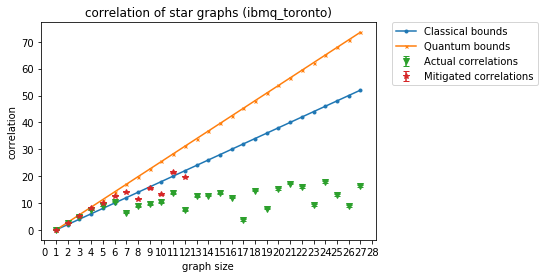

In [31]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds[:max_size], label="Classical bounds", marker="o", markersize=3)
plt.plot(list(range(1, max_size + 1)), q_bounds[:max_size], label="Quantum bounds", marker="x", markersize=3)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real[:max_size], label="Actual correlations", fmt="v", yerr=stddev_list_real[:max_size], capsize=3)
plt.errorbar(list(range(1, tensored_size + 1)), tensored_corr_list_real[:tensored_size], label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real[:tensored_size], capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.title("correlation of star graphs (ibmq_toronto)")
plt.show()

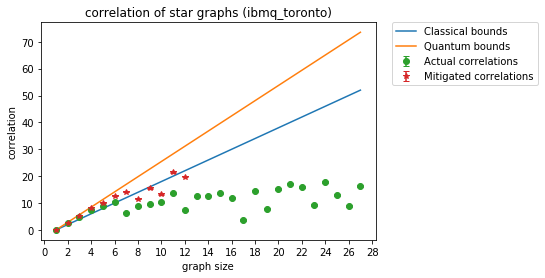

In [32]:
# max_size = 22
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds[:max_size], label="Classical bounds") # , marker="o", markersize=3)
plt.plot(list(range(1, max_size + 1)), q_bounds[:max_size], label="Quantum bounds") # , marker="x", markersize=3)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real[:max_size], label="Actual correlations", fmt="o", yerr=stddev_list_real[:max_size], capsize=3)
plt.errorbar(list(range(1, tensored_size + 1)), tensored_corr_list_real[:tensored_size], label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real[:tensored_size], capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2))[::2])
plt.title("correlation of star graphs (ibmq_toronto)")
plt.show()

In [33]:
each_corr_list = [[0]] + [E_1 + Es_2 for E_1, Es_2 in Es_list_real[1:]]
tp_each_corr_list = []
for i in range(len(each_corr_list)):
    tp_each_corr_list.append([each_corr_list[j][i] for j in range(i, len(each_corr_list))])

In [34]:
each_stddev_list = [[0]] + [D_1 + Ds_2 for D_1, Ds_2 in Ds_list_real[1:]]
tp_each_stddev_list = []
for i in range(len(each_stddev_list)):
    tp_each_stddev_list.append([each_stddev_list[j][i] for j in range(i, len(each_stddev_list))])

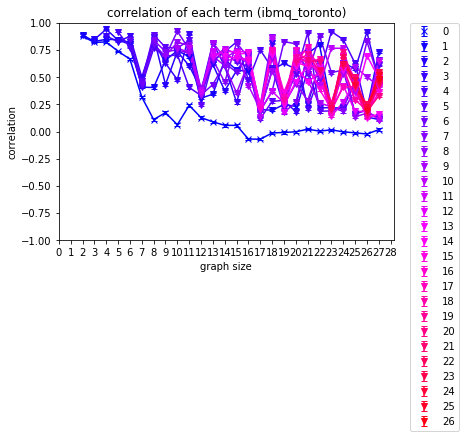

In [35]:
# max_size = 27
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(tp_each_corr_list, tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, max_size + 1)), each_corr[1:], color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(2, max_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, max_size + 1)), each_corr, color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(i+1, max_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, max_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.ylim([-1,1])
plt.title("correlation of each term (ibmq_toronto)")
plt.show()

In [36]:
mitigated_each_corr_list = [[0]] + [E_1 + Es_2 for E_1, Es_2 in tensored_Es_list_real[1:]]
mitigated_tp_each_corr_list = []
for i in range(len(mitigated_each_corr_list)):
    mitigated_tp_each_corr_list.append([mitigated_each_corr_list[j][i] for j in range(i, len(mitigated_each_corr_list))])

In [37]:
mitigated_each_stddev_list = [[0]] + [D_1 + Ds_2 for D_1, Ds_2 in tensored_Ds_list_real[1:]]
mitigated_tp_each_stddev_list = []
for i in range(len(mitigated_each_stddev_list)):
    mitigated_tp_each_stddev_list.append([mitigated_each_stddev_list[j][i] for j in range(i, len(mitigated_each_stddev_list))])

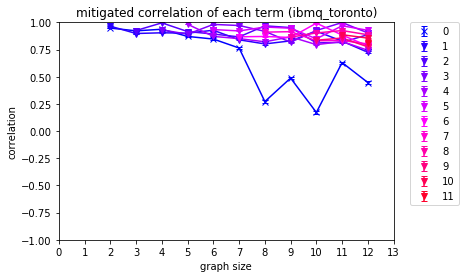

In [38]:
# tensored_size = 22
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, tensored_size + 1)), each_corr[1:], color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(2, tensored_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, tensored_size + 1)), each_corr, color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(i+1, tensored_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, tensored_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(tensored_size + 2)))
plt.ylim([-1,1])
plt.title("mitigated correlation of each term (ibmq_toronto)")
plt.show()

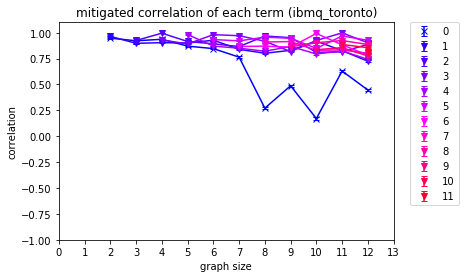

In [39]:
# tensored_size = 22
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, tensored_size + 1)), each_corr[1:], color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(2, tensored_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, tensored_size + 1)), each_corr, color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(i+1, tensored_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, tensored_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(tensored_size + 2)))
plt.ylim([-1,1.1])
plt.title("mitigated correlation of each term (ibmq_toronto)")
plt.show()

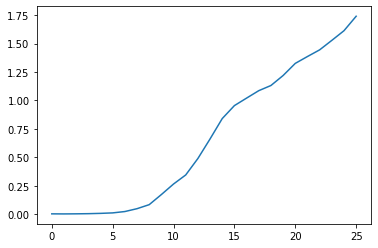

In [32]:
plt.clf()
plt.plot(times)